# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

12:13:18 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=184269;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=276665;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=727525;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=74390;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

12:14:16 INFO      Auto-determined polynomial order: 0                                ]8;id=682152;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=71689;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

12:14:35 INFO      None 0-order polynomial fit with the mle method                               ]8;id=851912;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=139309;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=752509;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=158628;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=181654;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=885682;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=261921;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=237802;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=316803;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=883613;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=746644;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=678392;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=958121;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=364637;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=898200;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=724392;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=104125;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=711048;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

12:14:38 INFO      Now using 120 bins                                                          ]8;id=909392;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=47848;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

12:14:41 INFO      Auto-determined polynomial order: 1                                ]8;id=606242;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=828078;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

12:15:00 INFO      None 1-order polynomial fit with the mle method                               ]8;id=346904;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=641990;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=302;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=476137;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=137991;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=779275;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

12:15:01 INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=37317;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=772439;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=16188;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=285982;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=463545;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=162130;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=338413;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=445582;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=476180;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=282819;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=443640;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=110155;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=552070;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=464721;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

12:15:03 INFO      Auto-determined polynomial order: 1                                ]8;id=924303;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=678335;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

12:15:23 INFO      None 1-order polynomial fit with the mle method                               ]8;id=922404;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=45188;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=905373;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=442619;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=280813;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=827953;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=531441;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=882280;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=517684;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=997970;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

12:15:24 INFO      Auto-probed noise models:                                                    ]8;id=388060;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=628749;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=440867;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=543242;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=993255;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=407762;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=592059;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=959690;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=173630;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=499184;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

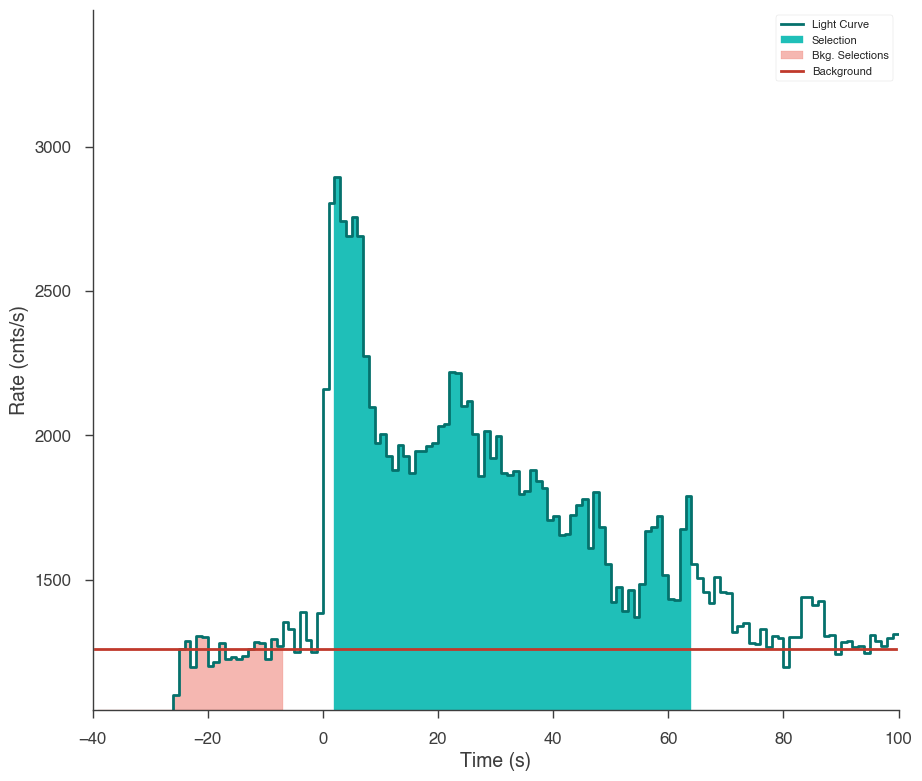

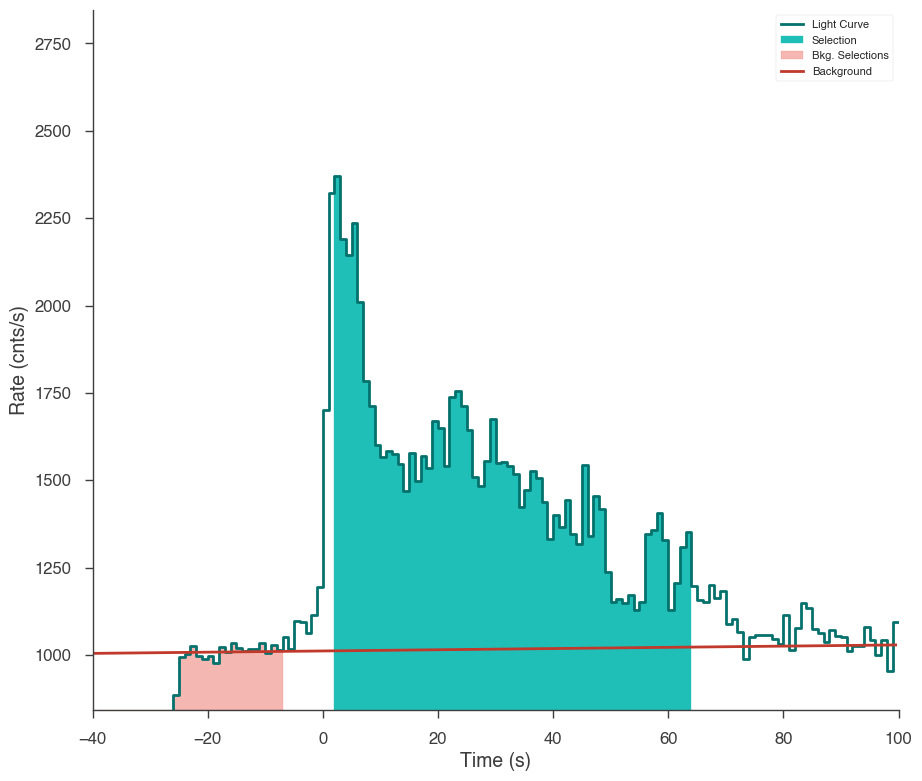

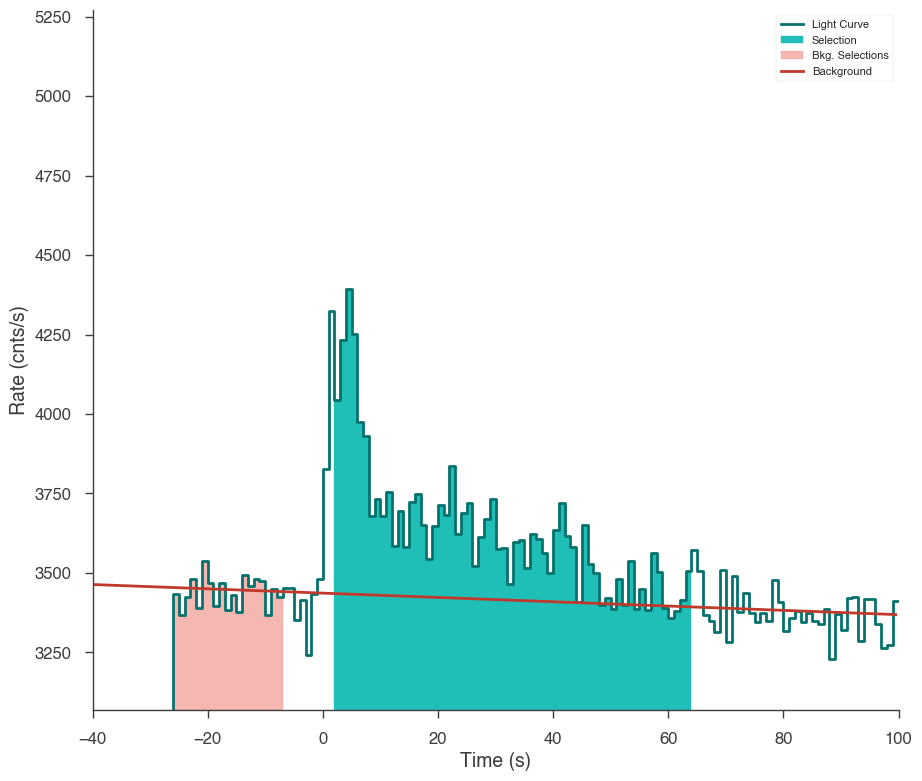

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

12:15:25 INFO      sampler set to multinest                                                ]8;id=980496;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=298778;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

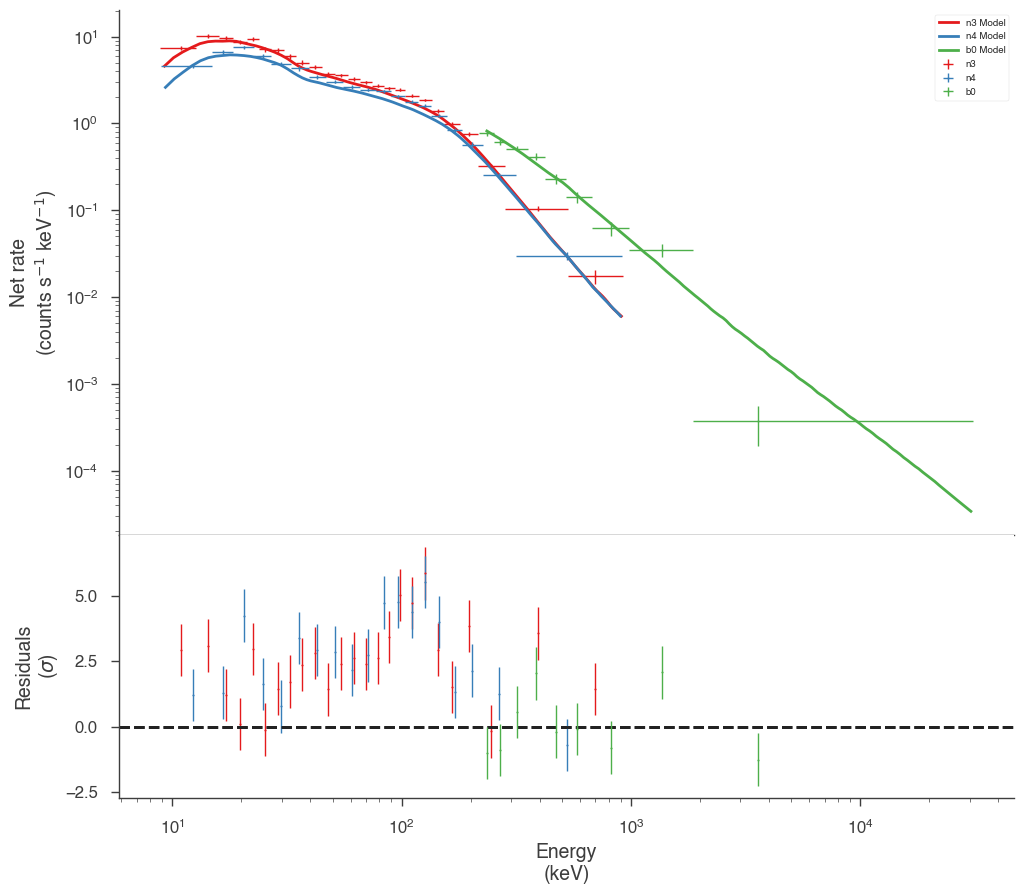

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


 ln(ev)=  -3101.7674801916842      +/-  0.22764875108347818     
  analysing data from chains/fit-.txt
 Total Likelihood Evaluations:        20104
 Sampling finished. Exiting MultiNest


12:15:48 INFO      fit restored to maximum of posterior                                         ]8;id=194396;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=760109;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=250301;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=296489;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
GRB080916009...K,(1.443 +0.010 +0.05) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.108 +0.015 +0.05,
GRB080916009...break_energy,(1.977 +0.005 +0.5) x 10^2,keV
GRB080916009...break_scale,(0.0 +1.6 +3.3) x 10^-1,
GRB080916009...beta,-1.989 -0.17 -0.013,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0,-1049.533221
n3,-1019.051547
n4,-1011.625070
total,-3080.209838


Values of statistical measures:

,statistical measures
AIC,6170.590131
BIC,6189.822342
DIC,6179.203751
PDIC,4.120902
log(Z),-1347.080501


Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=132149;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=9609;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

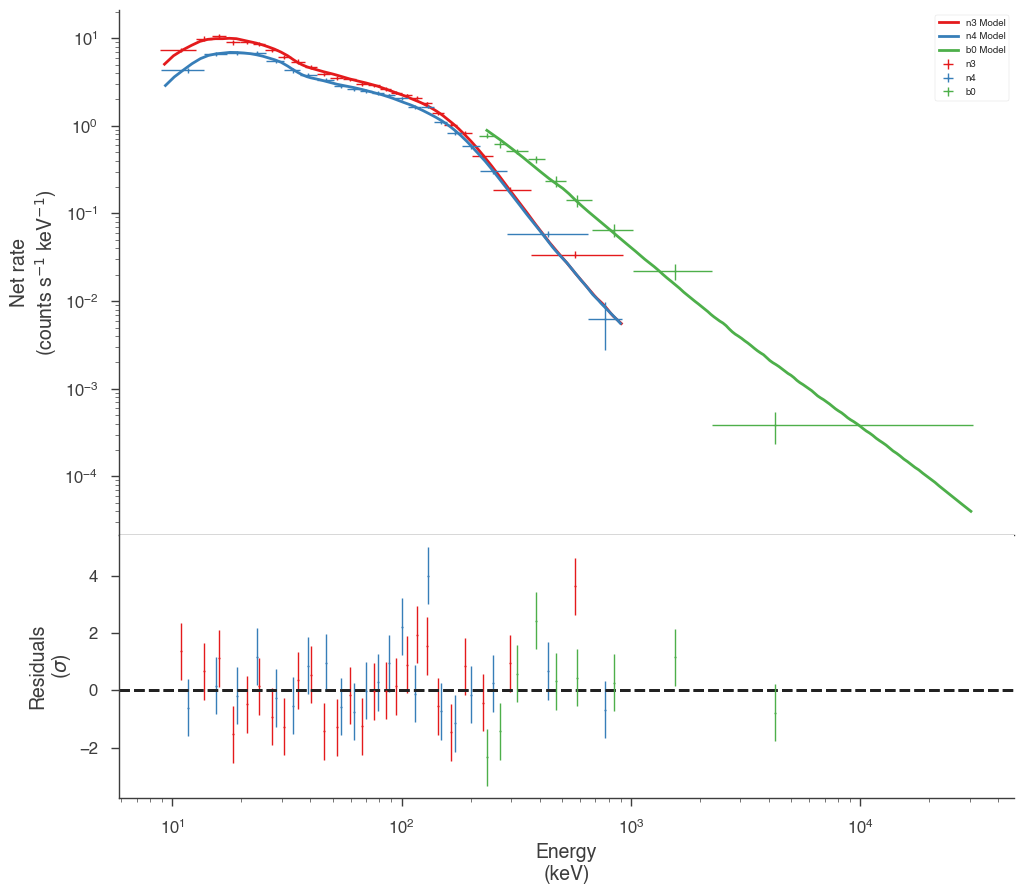

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

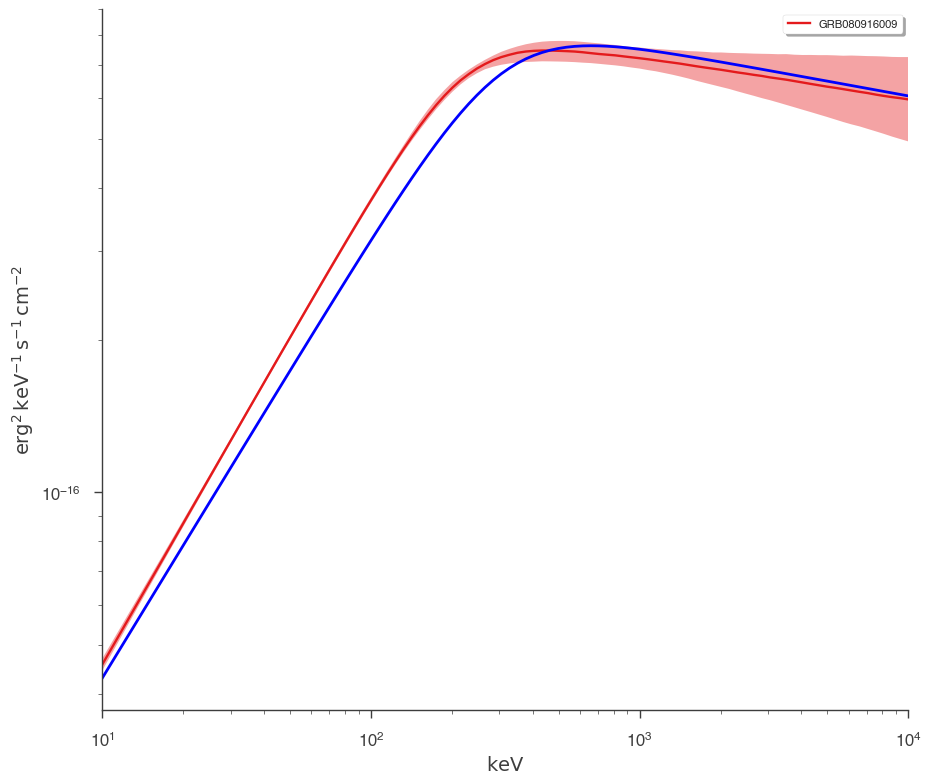

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

12:18:01 INFO      Created 15 bins via bayesblocks                                       ]8;id=499361;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=739516;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


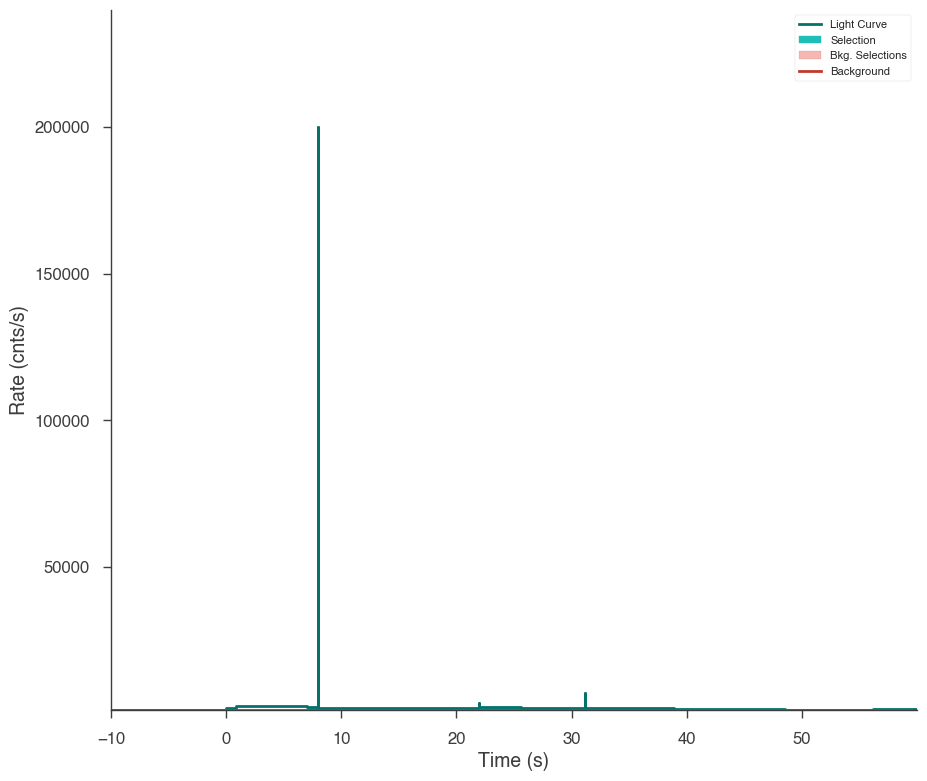

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

         INFO      Created 12 bins via custom                                            ]8;id=441282;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=661871;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

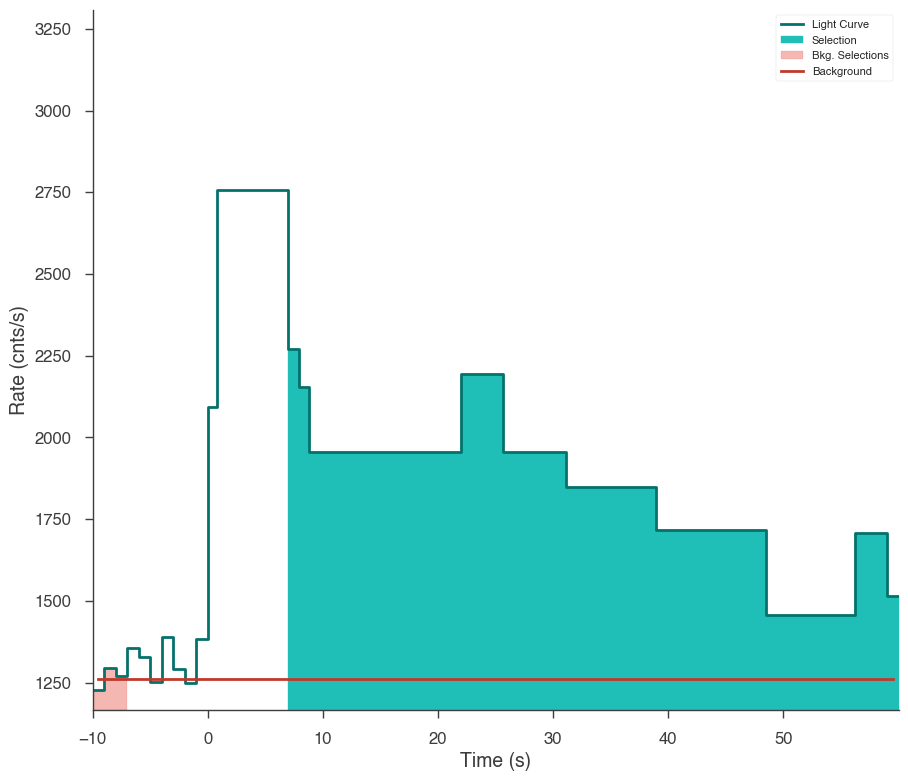

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

         INFO      Created 12 bins via custom                                            ]8;id=780830;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=270030;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

12:18:02 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=971973;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=132652;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=595645;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=284896;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

12:18:03 INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=292836;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=80010;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=753923;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=247077;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

12:18:04 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=818594;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=332754;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=733613;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=587368;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=59327;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=38476;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=729722;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=827298;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=598547;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=369534;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=832122;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=690262;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 107 bins                                                          ]8;id=77292;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=430262;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=938059;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=199121;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -789.90415994324042      +/-  0.18221173183454953     
 Total Likelihood Evaluations:        16737
 Sampling finished. Exiting MultiNest



12:18:22 INFO      fit restored to maximum of posterior                                         ]8;id=477259;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=931491;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=579274;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=901578;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.50 -0.26 +1.1) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.7 -0.9 +1.8) x 10^-1,
grb.spectrum.main.Band.xp,(3.17 -0.8 +0.28) x 10^2,keV
grb.spectrum.main.Band.beta,-2.00 -0.17 +0.14,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval0,-285.743731
n3_interval0,-250.212033
n4_interval0,-267.911427
total,-803.867191


Values of statistical measures:

,statistical measures
AIC,1615.847697
BIC,1631.256514
DIC,1570.307153
PDIC,2.440459
log(Z),-343.051018


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=835644;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=846982;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=456243;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=753313;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=218274;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=628340;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=598976;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=877208;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=307135;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=376686;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=997536;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=241946;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=104973;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=75142;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1944.2772642781847      +/-  0.21565956095092065     
 Total Likelihood Evaluations:        24106
 Sampling finished. Exiting MultiNest



12:18:47 INFO      fit restored to maximum of posterior                                         ]8;id=933790;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=889887;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=471034;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=899961;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(4.1467 +0.0020 +0.18) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.541 -0.008 +0.4) x 10^-1,
grb.spectrum.main.Band.xp,(6.125 -0.6 +0.025) x 10^2,keV
grb.spectrum.main.Band.beta,-2.12 -0.09 +0.08,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval1,-674.048619
n3_interval1,-641.693168
n4_interval1,-645.257063
total,-1960.998850


Values of statistical measures:

,statistical measures
AIC,3930.111015
BIC,3945.519832
DIC,3872.657213
PDIC,3.023426
log(Z),-844.388887


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=368202;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=618577;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=419895;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=514511;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=209083;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=934231;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=803922;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=732048;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=460337;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=326538;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 115 bins                                                          ]8;id=380661;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=327787;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=103922;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=880917;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -906.91244898312755      +/-  0.19352011881824849     
 Total Likelihood Evaluations:        20141
 Sampling finished. Exiting MultiNest



12:19:09 INFO      fit restored to maximum of posterior                                         ]8;id=114409;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=163972;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=831353;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=256976;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.56 -0.13 +0.30) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.04 -0.05 +0.06,
grb.spectrum.main.Band.xp,(5.7 -1.6 +0.9) x 10^2,keV
grb.spectrum.main.Band.beta,-1.87 -0.14 +0.12,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval2,-324.361251
n3_interval2,-288.911114
n4_interval2,-312.371453
total,-925.643817


Values of statistical measures:

,statistical measures
AIC,1859.400949
BIC,1874.809767
DIC,1804.376238
PDIC,2.501519
log(Z),-393.867072


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=560335;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=25940;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=980183;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=882376;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=533580;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=96597;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=805257;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=195094;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=776346;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=348224;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 109 bins                                                          ]8;id=80274;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=917874;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=512785;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=659846;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.76929465267631      +/-  0.17805645955712651     
 Total Likelihood Evaluations:        17598
 Sampling finished. Exiting MultiNest



12:19:27 INFO      fit restored to maximum of posterior                                         ]8;id=954458;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=889261;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=419490;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=63905;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.81 -0.17 +0.6) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.5 -0.6 +1.2) x 10^-1,
grb.spectrum.main.Band.xp,(3.5 -0.8 +0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.24 -0.16 +0.27,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval3,-298.551902
n3_interval3,-242.659757
n4_interval3,-262.598462
total,-803.810121


Values of statistical measures:

,statistical measures
AIC,1615.733557
BIC,1631.142374
DIC,1569.774872
PDIC,2.525897
log(Z),-342.558152


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=128705;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=59100;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=943926;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=950242;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=805744;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=680835;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=851927;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=33904;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=641523;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=53427;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=669440;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=166312;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=251822;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=389768;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2270.4494697936784      +/-  0.19657798939876267     
 Total Likelihood Evaluations:        20854
 Sampling finished. Exiting MultiNest



12:19:48 INFO      fit restored to maximum of posterior                                         ]8;id=4521;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=176261;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=515770;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=805807;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.08 -0.15 +0.07) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.72 -0.5 +0.27) x 10^-1,
grb.spectrum.main.Band.xp,(3.90 -0.27 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-1.96 -0.13 +0.06,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval4,-778.435692
n3_interval4,-757.331363
n4_interval4,-746.419273
total,-2282.186328


Values of statistical measures:

,statistical measures
AIC,4572.485970
BIC,4587.894787
DIC,4528.214698
PDIC,3.623287
log(Z),-986.043676


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=841859;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=331647;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=979589;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=611534;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=267702;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=872931;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=448720;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=749630;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=357161;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=551405;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=148333;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=724401;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=827596;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=968079;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -1573.0773904392197      +/-  0.19099988714764210     
 Total Likelihood Evaluations:        19762
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


12:20:08 INFO      fit restored to maximum of posterior                                         ]8;id=930289;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=485658;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=70779;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=738590;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.81 -0.21 +0.17) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.0 -0.6 +0.4) x 10^-1,
grb.spectrum.main.Band.xp,(4.2 -0.4 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-2.12 -0.30 +0.08,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval5,-536.733449
n3_interval5,-523.690641
n4_interval5,-527.500821
total,-1587.924911


Values of statistical measures:

,statistical measures
AIC,3183.963136
BIC,3199.371954
DIC,3137.097321
PDIC,3.536944
log(Z),-683.178830


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=919229;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=465201;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=14905;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=469321;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=620896;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=165099;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=684970;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=401322;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=249992;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=436608;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=948399;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=44446;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=356127;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=294725;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1755.7637023446380      +/-  0.19680048531822422     
 Total Likelihood Evaluations:        18822
 Sampling finished. Exiting MultiNest



12:20:28 INFO      fit restored to maximum of posterior                                         ]8;id=889162;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=773163;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=97226;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=948504;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.97 -0.11 +0.09) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.004 -0.04 +0.031,
grb.spectrum.main.Band.xp,(4.4 -0.4 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.34 -0.4 +0.08,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval6,-609.555067
n3_interval6,-584.216214
n4_interval6,-576.788358
total,-1770.559639


Values of statistical measures:

,statistical measures
AIC,3549.232593
BIC,3564.641411
DIC,3499.800330
PDIC,2.641301
log(Z),-762.518487


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=602698;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=385191;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=845428;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=644735;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=58771;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=529143;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=842824;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=392259;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=452793;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=889241;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=400723;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=772395;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=376717;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=561936;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1939.8517380642386      +/-  0.19370342788604719     
 Total Likelihood Evaluations:        19574
 Sampling finished. Exiting MultiNest



12:20:48 INFO      fit restored to maximum of posterior                                         ]8;id=139591;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=694879;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=58123;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=980618;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.67 -0.09 +0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.04 -0.04 +0.05,
grb.spectrum.main.Band.xp,(4.3 +/- 0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-2.26 -0.17 +0.18,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval7,-662.259949
n3_interval7,-640.777500
n4_interval7,-650.511938
total,-1953.549386


Values of statistical measures:

,statistical measures
AIC,3915.212087
BIC,3930.620904
DIC,3868.082233
PDIC,3.113245
log(Z),-842.466906


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=990072;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=709454;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=800682;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=458365;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=366180;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=511893;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=662187;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=946977;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=774361;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=826648;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=18380;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=967864;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=298707;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=779793;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2053.9849920077081      +/-  0.18801917128973433     
 Total Likelihood Evaluations:        19020
 Sampling finished. Exiting MultiNest



12:21:08 INFO      fit restored to maximum of posterior                                         ]8;id=592330;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=273691;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=945664;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=588679;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.54 +/- 0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.4 -0.6 +0.5) x 10^-1,
grb.spectrum.main.Band.xp,(3.7 -0.4 +0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-2.33 -0.4 +0.16,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval8,-702.196312
n3_interval8,-698.472507
n4_interval8,-666.209920
total,-2066.878739


Values of statistical measures:

,statistical measures
AIC,4141.870793
BIC,4157.279610
DIC,4098.183464
PDIC,3.292515
log(Z),-892.034348


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=741567;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=646474;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=437537;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=871360;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=652465;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=418462;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=684619;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=157543;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=581137;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=322752;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=948442;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=726114;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=116542;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=884016;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1879.2702761673891      +/-  0.14976749008954210     
 Total Likelihood Evaluations:        12779
 Sampling finished. Exiting MultiNest



12:21:21 INFO      fit restored to maximum of posterior                                         ]8;id=171207;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=821744;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=472413;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=15246;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(10.0 -2.6 +7) x 10^-3,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.1 -1.5 +2.7) x 10^-1,
grb.spectrum.main.Band.xp,(1.22 -0.33 +0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-1.890 -0.4 +0.033,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval9,-648.423394
n3_interval9,-617.142694
n4_interval9,-616.344159
total,-1881.910246


Values of statistical measures:

,statistical measures
AIC,3771.933806
BIC,3787.342624
DIC,3689.119569
PDIC,-58.096694
log(Z),-816.156711


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=147200;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=947194;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=83437;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=631523;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=68837;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=346901;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=608698;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=137258;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=382210;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=900250;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=470074;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=566968;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=873045;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=161306;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1322.5809155242932      +/-  0.16895618597865145     
 Total Likelihood Evaluations:        15079
 Sampling finished. Exiting MultiNest



12:21:37 INFO      fit restored to maximum of posterior                                         ]8;id=844711;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=976004;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=635598;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=229463;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.09 -0.16 +0.6) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.3 -0.5 +1.6) x 10^-1,
grb.spectrum.main.Band.xp,(2.14 -0.5 +0.29) x 10^2,keV
grb.spectrum.main.Band.beta,-1.96 -0.4 +0.16,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval10,-460.719543
n3_interval10,-437.775467
n4_interval10,-433.080084
total,-1331.575095


Values of statistical measures:

,statistical measures
AIC,2671.263504
BIC,2686.672322
DIC,2634.901494
PDIC,1.351187
log(Z),-574.389593


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=976047;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=739106;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=848313;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=49896;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=30178;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=717002;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=837143;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=261789;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=687486;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=620878;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=322878;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=163347;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=232394;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=469677;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -811.76363602283209      +/-  0.14576661425313409     
 Total Likelihood Evaluations:        12134
 Sampling finished. Exiting MultiNest



12:21:50 INFO      fit restored to maximum of posterior                                         ]8;id=295107;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=186566;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=326321;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=844425;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.8 -0.7 +2.1) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-4.8 -1.9 +3.1) x 10^-1,
grb.spectrum.main.Band.xp,(1.32 -0.32 +0.24) x 10^2,keV
grb.spectrum.main.Band.beta,-2.12 -0.4 +0.22,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval11,-292.443046
n3_interval11,-272.437503
n4_interval11,-255.914772
total,-820.795321


Values of statistical measures:

,statistical measures
AIC,1649.703956
BIC,1665.112774
DIC,1616.998678
PDIC,-0.211700
log(Z),-352.544468


### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=137685;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=557926;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:21:51 INFO      fit restored to median of posterior                                          ]8;id=265008;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=547706;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:21:52 INFO      fit restored to median of posterior                                          ]8;id=860238;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=665476;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:21:53 INFO      fit restored to median of posterior                                          ]8;id=11810;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=640155;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:21:54 INFO      fit restored to median of posterior                                          ]8;id=751810;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=650080;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:21:55 INFO      fit restored to median of posterior                                          ]8;id=76241;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=856032;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:21:56 INFO      fit restored to median of posterior                                          ]8;id=920883;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=417296;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:21:57 INFO      fit restored to median of posterior                                          ]8;id=558685;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=237059;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:21:58 INFO      fit restored to median of posterior                                          ]8;id=474525;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=600056;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:21:59 INFO      fit restored to median of posterior                                          ]8;id=868398;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=432675;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:22:00 INFO      fit restored to median of posterior                                          ]8;id=135751;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=383886;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=770883;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=274766;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

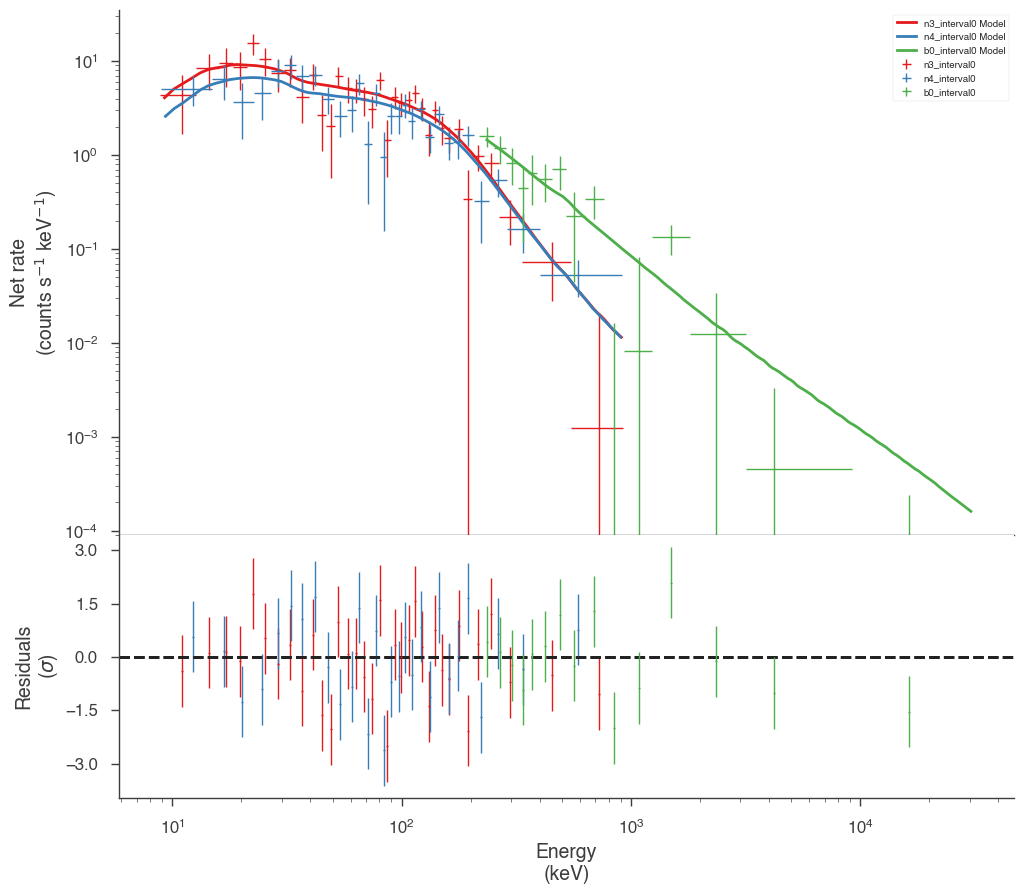

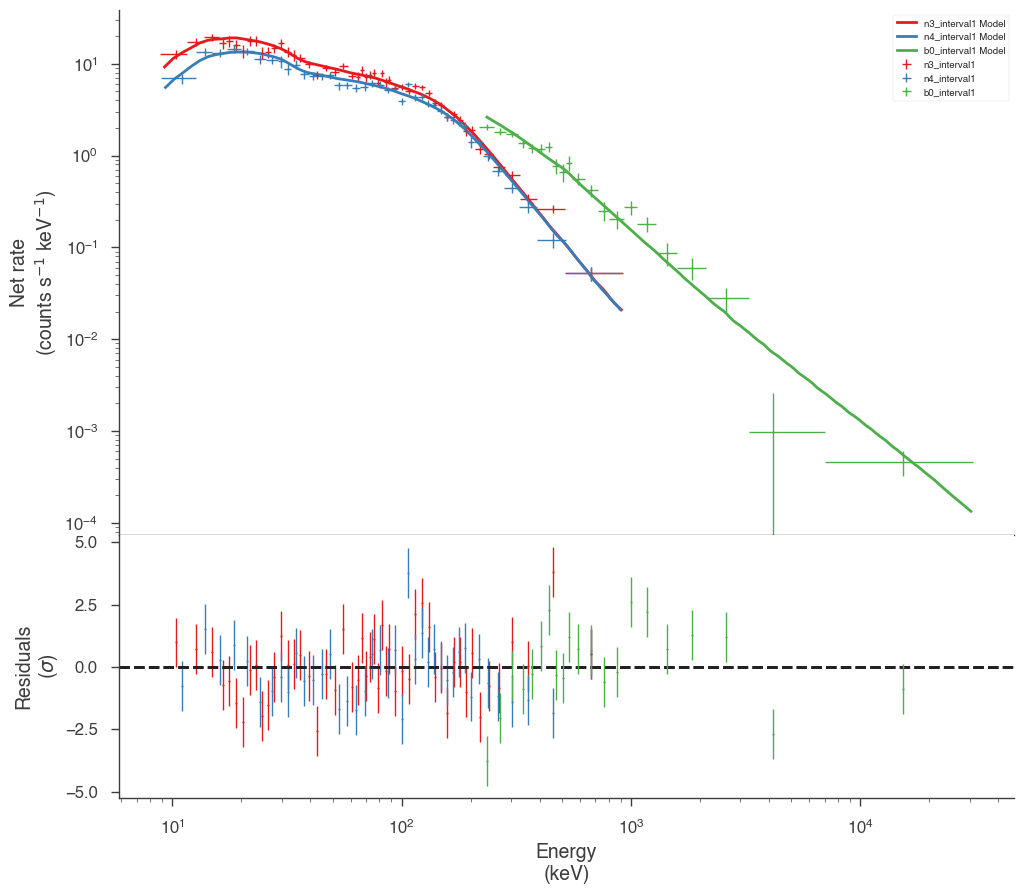

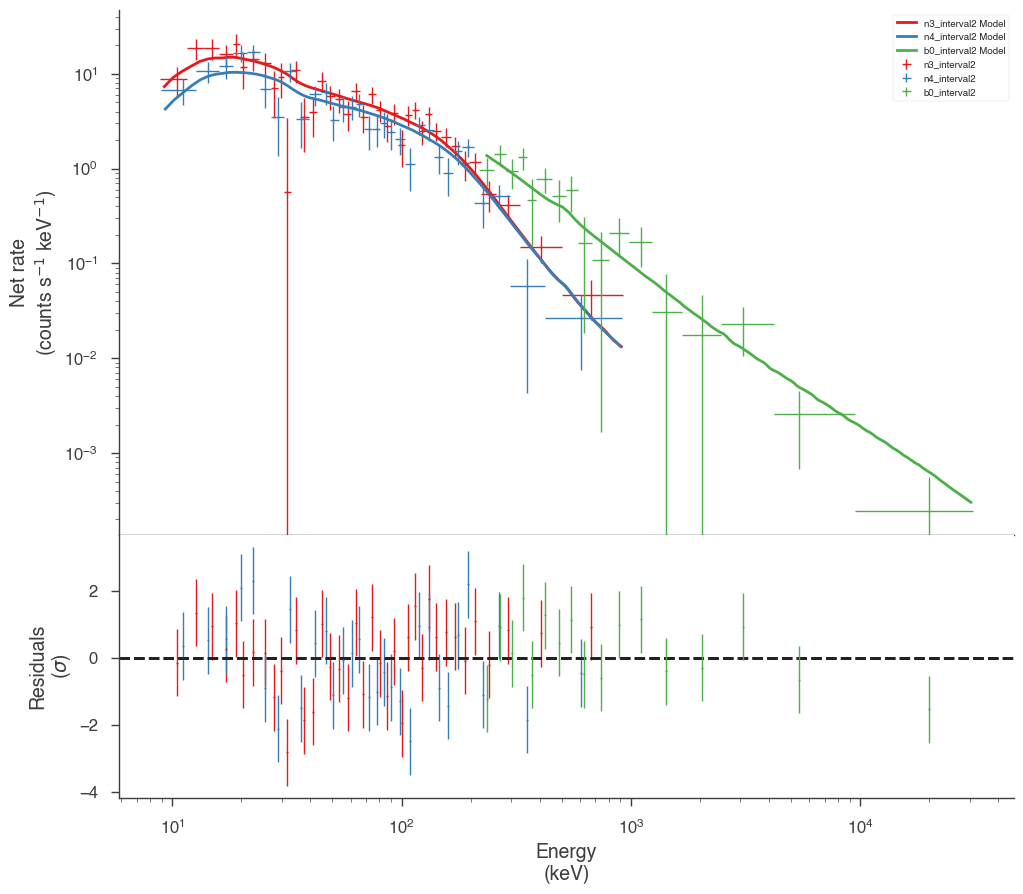

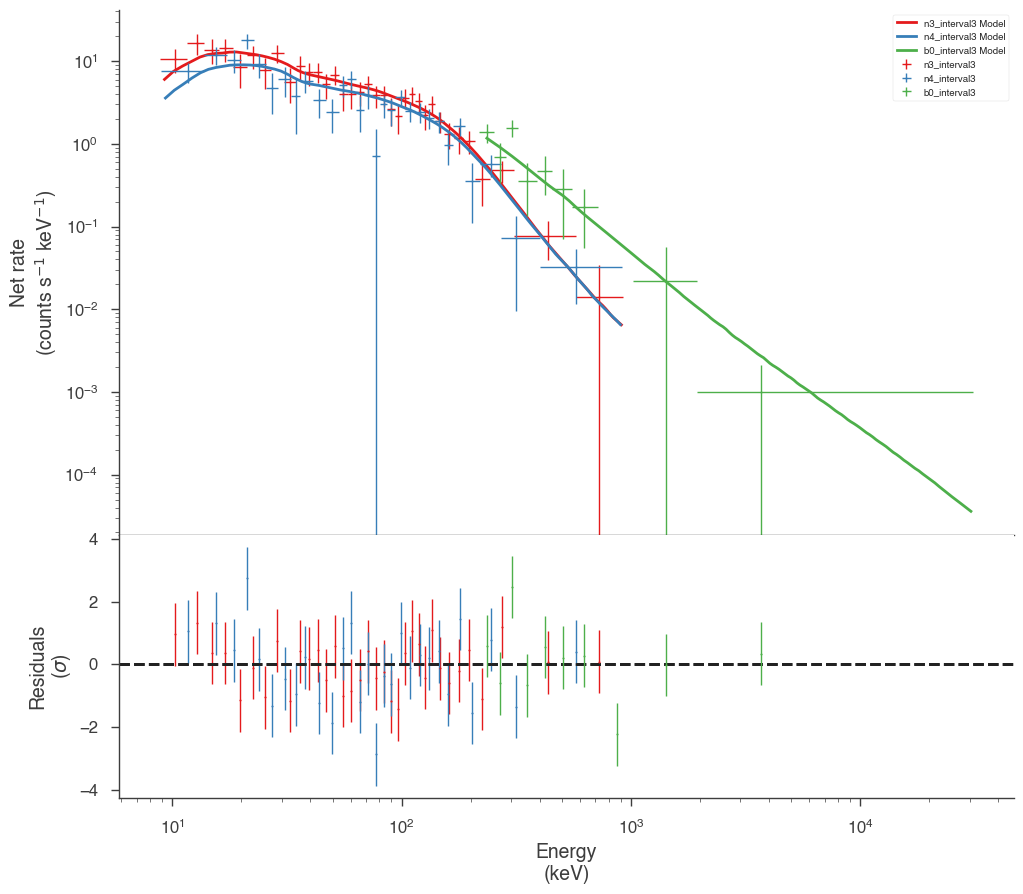

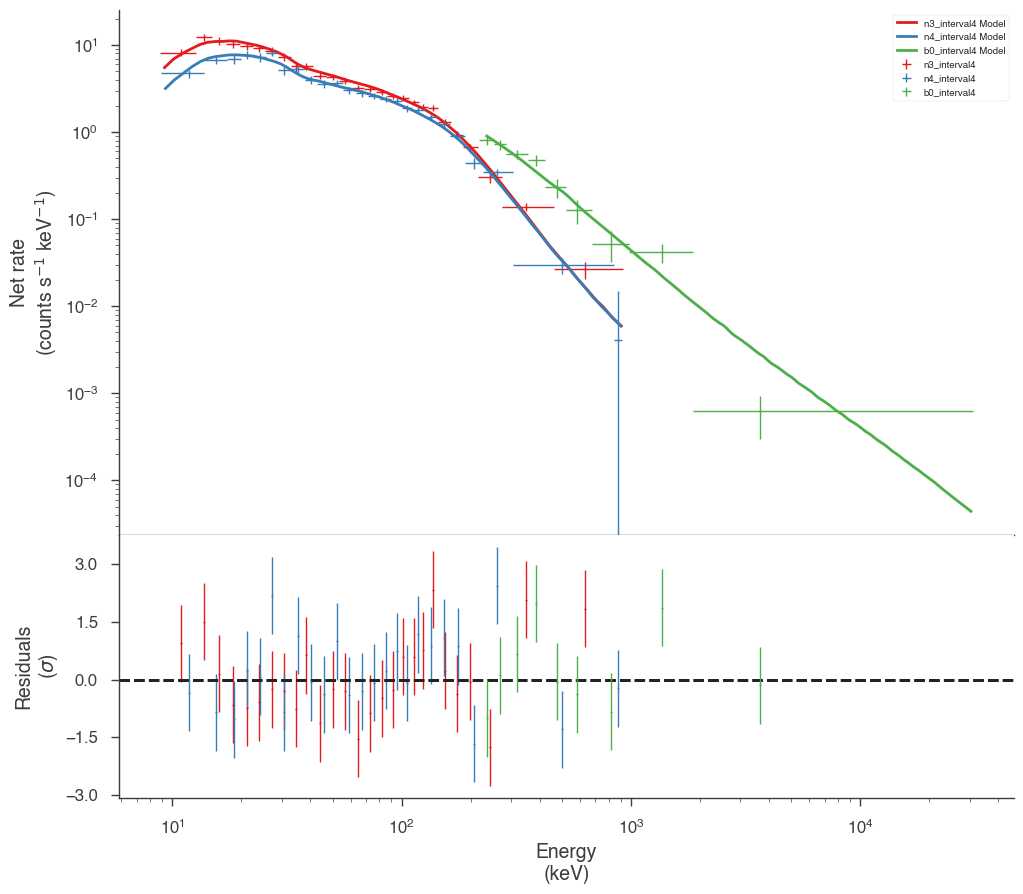

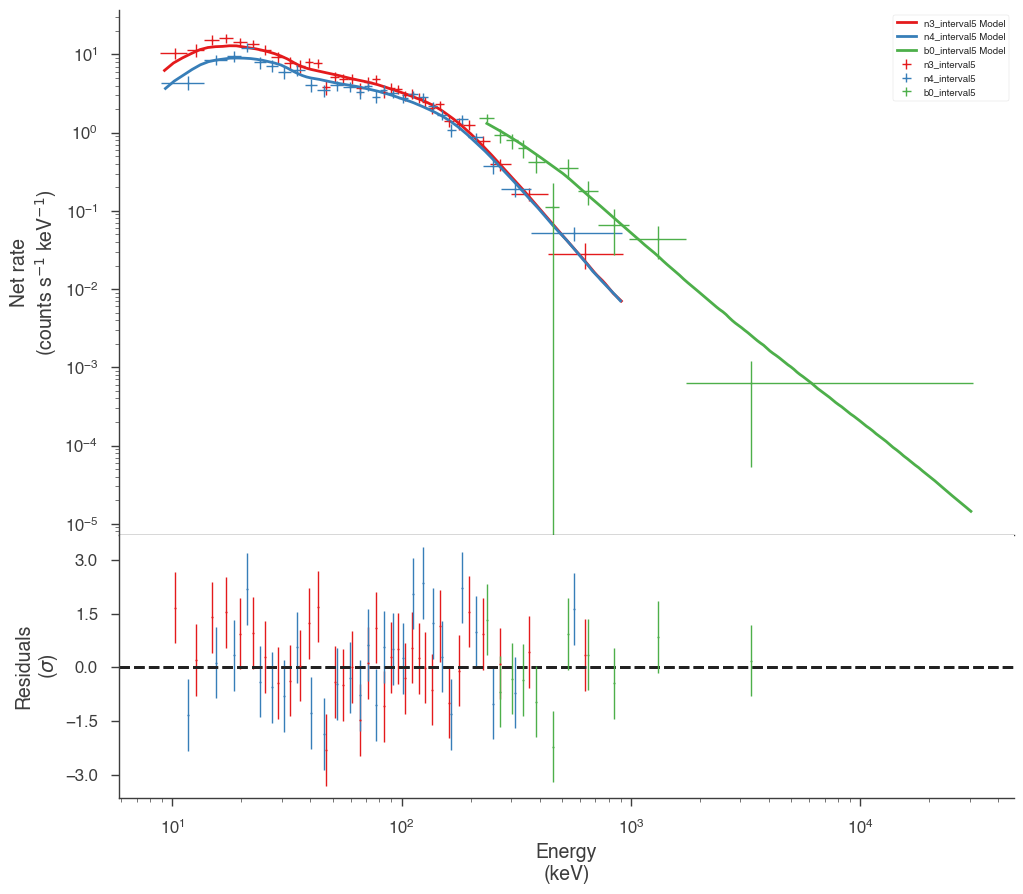

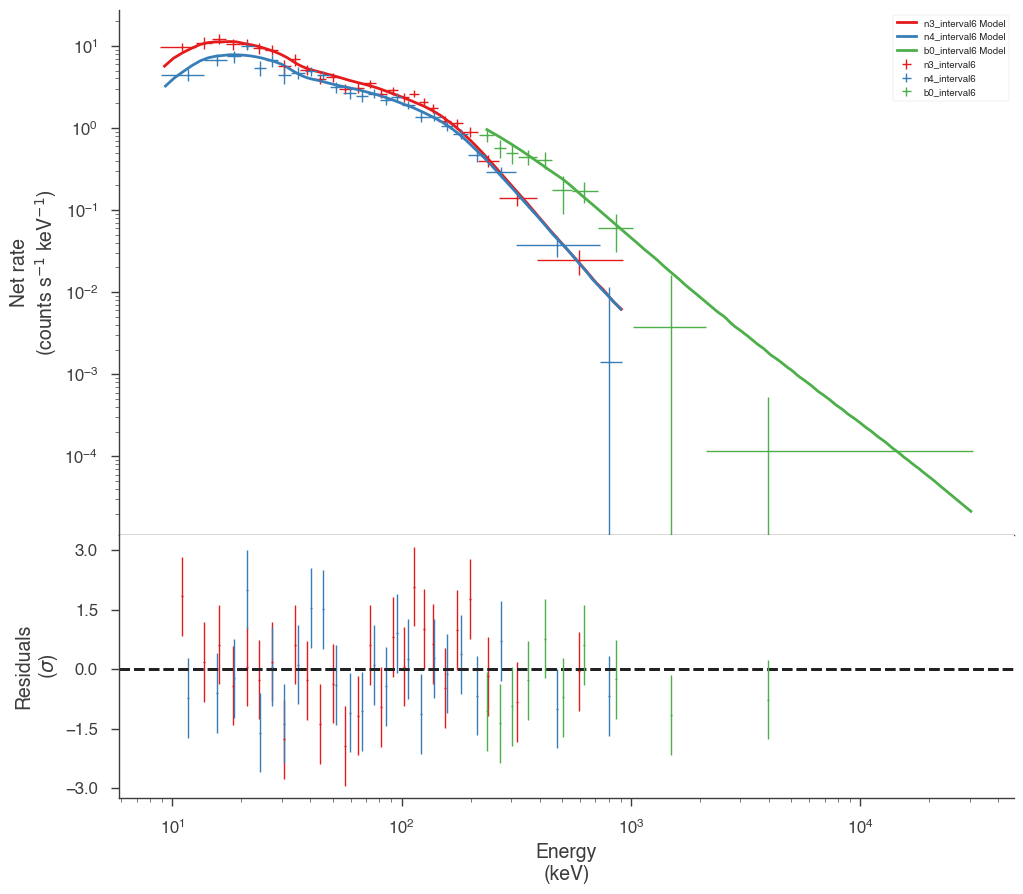

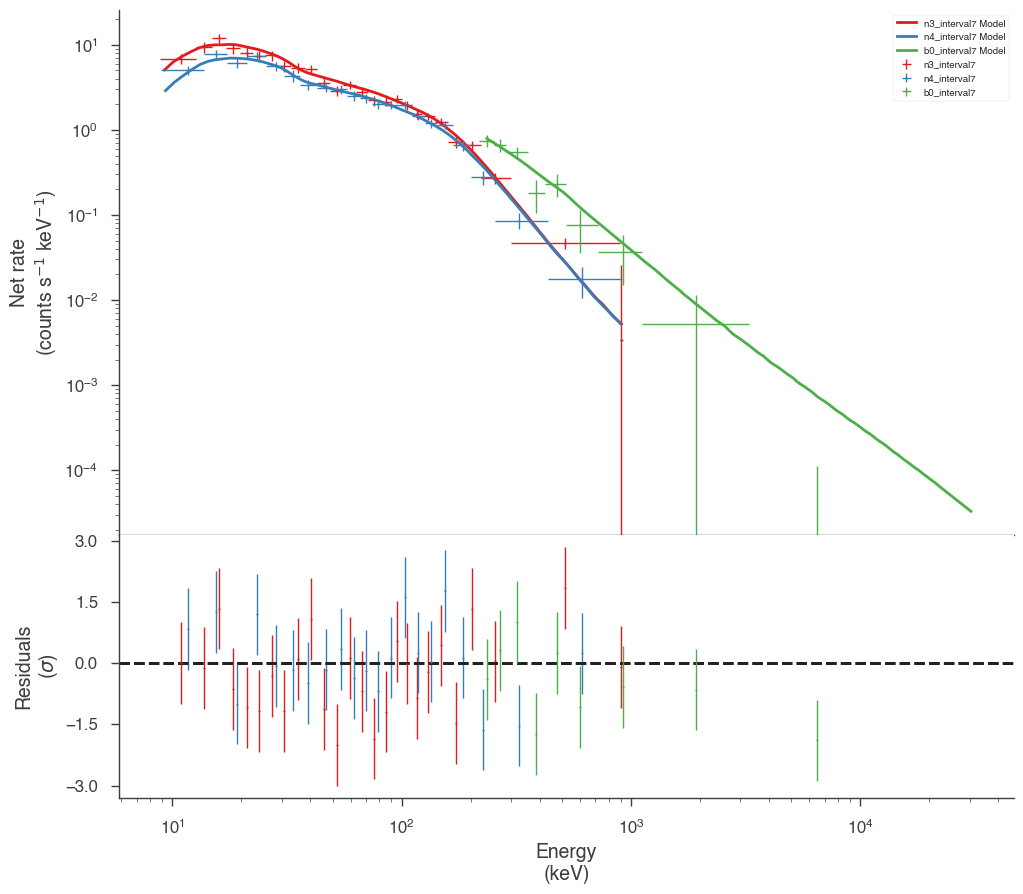

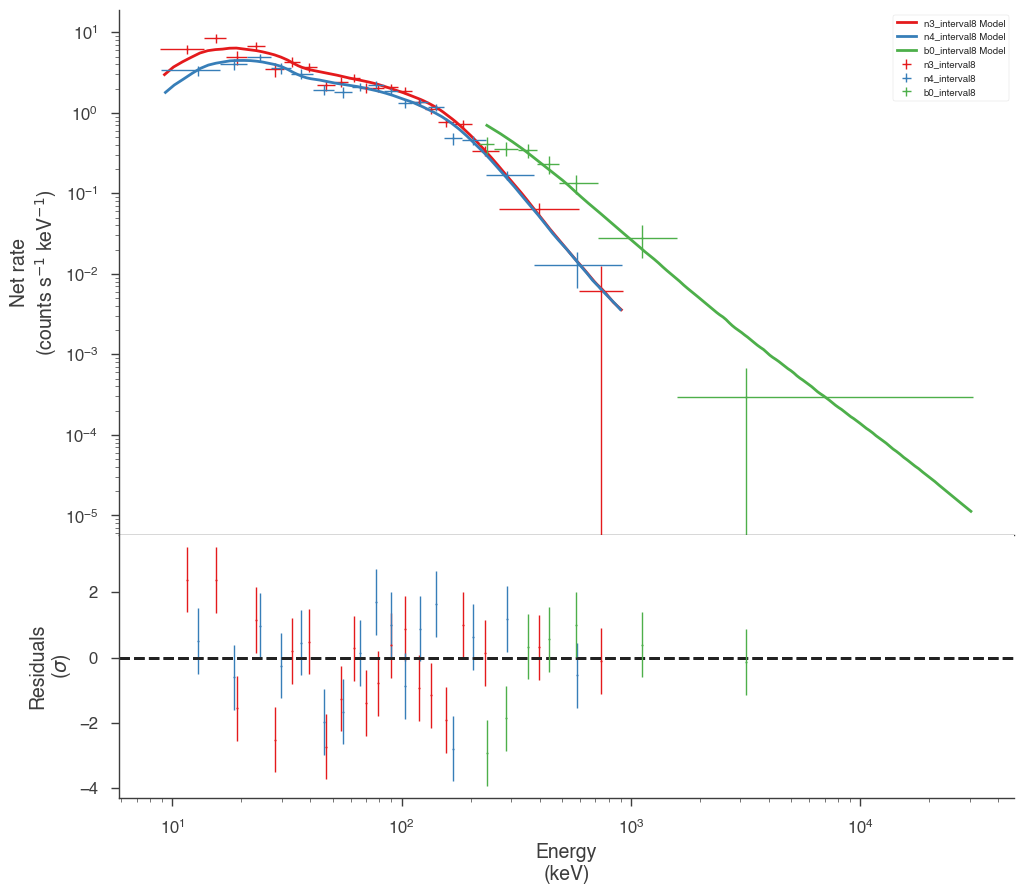

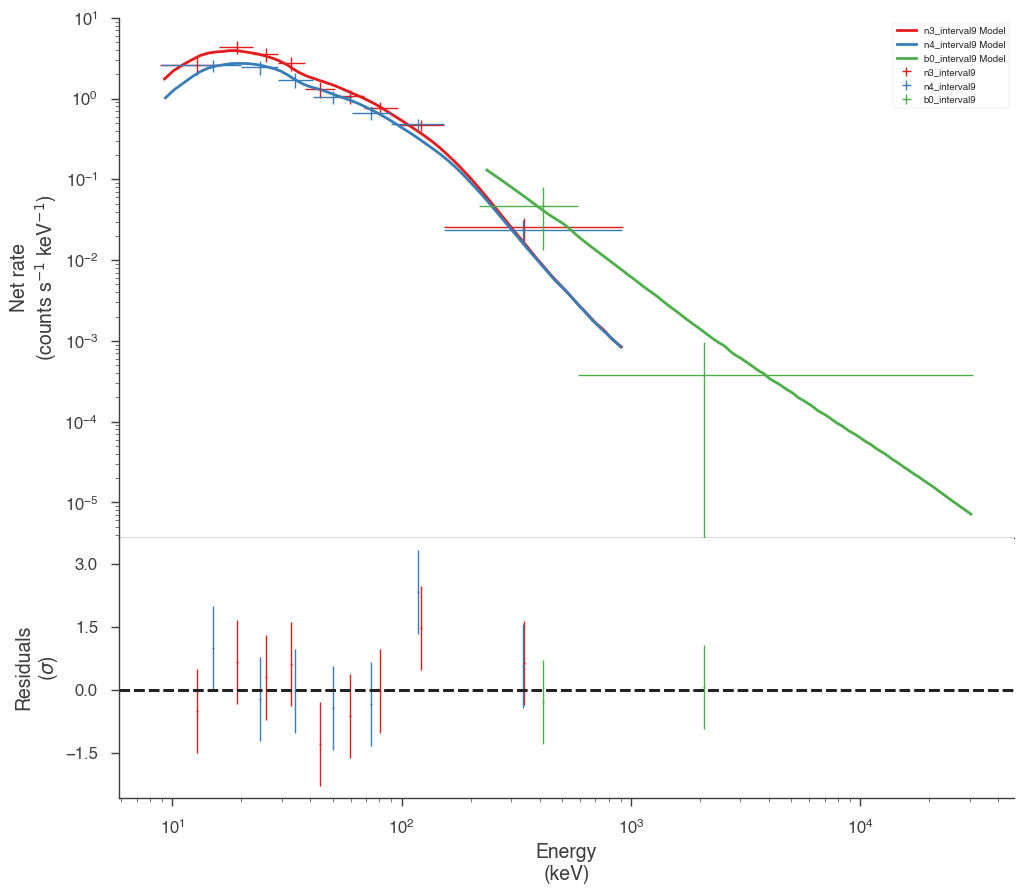

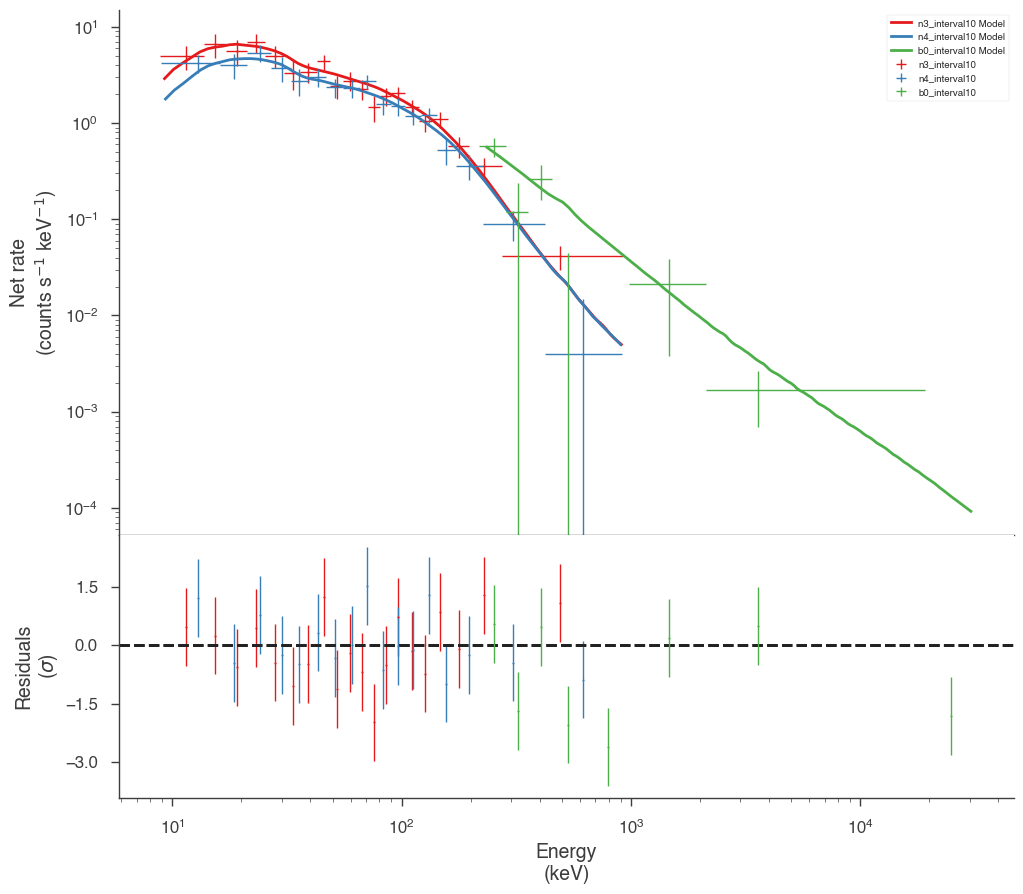

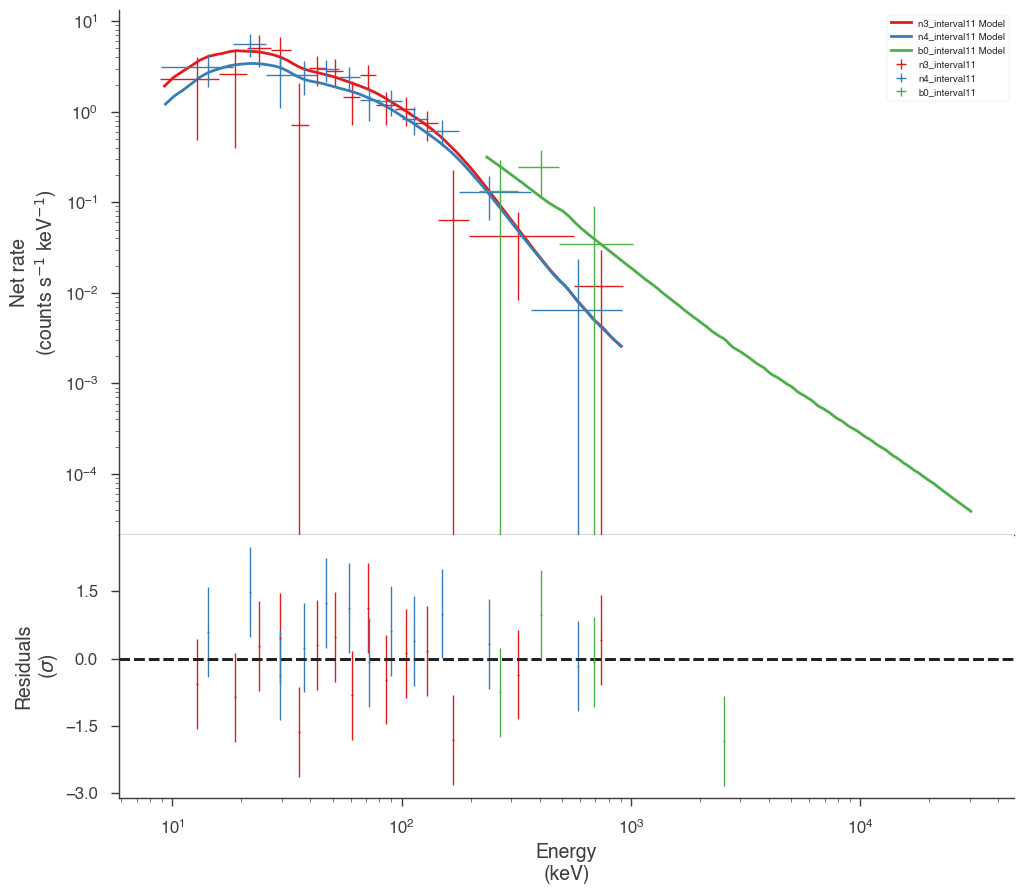

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

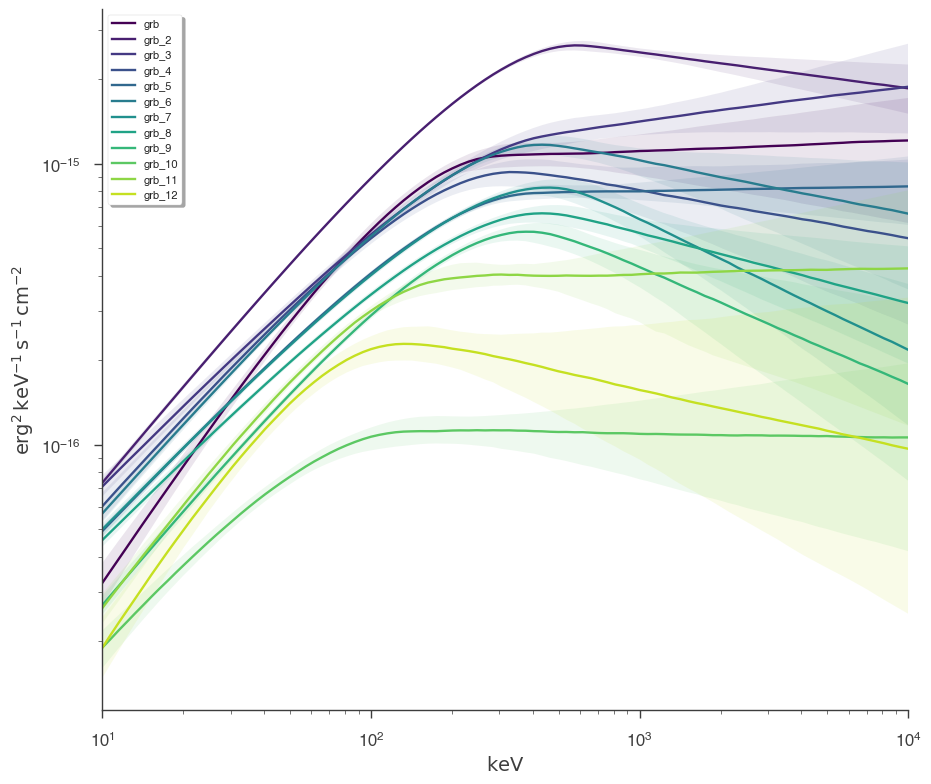

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.